# Sensitivity and Specificity Analyses

_Written by Frederic R. Hopp_

In this notebook, we analyze the sensitivity and specificity of the MJS.  
In particular, the following analyses are run: 
- Application of MJS, PINES, and VIDS to discovery, validation, replication and generalization cohorts
- Application of MJS PINES, and VIDS to PINES hold-out data
- Applicaiton of MJS, PINES, and VIDS to VIDS validation data 
- Application of MJS, PINES and VIDS to intentional vs. accidental harms 
- Application of MJS, PINES, and VIDS to socio-moral images
- Application of MJS, PINES, and VIDS to ultimatum game data. 

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pickle,json

from nltools.data import Brain_Data
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from scipy.stats import sem, pearsonr, permutation_test
import scipy.stats as stats
# from sklearn.metrics import root_mean_squared_error

from nilearn.plotting import plot_glass_brain

from nltools import expand_mask, collapse_mask
from nltools.mask import roi_to_brain, expand_mask, create_sphere

from nltools.stats import (
                           _calc_pvalue, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fdr,
                           zscore
)

from nltools.analysis import Roc
from tools import forced_choice_permutation_accuracy

from statistics import mean, stdev
from math import sqrt

%matplotlib inline

In [2]:
# Load Neural Biomarkers
mjs = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.nii.gz')
pines = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/external/PINES.nii.gz')
vids = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/external/VIDS.nii')

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


***
# Moral Wrongness Predictions

In [101]:
def bootstrap_pearsonr_ci(x, y, n_bootstrap=10000, ci=95, random_state=None):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Remove NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    rng = np.random.default_rng(random_state)
    n = len(x)
    boot_corrs = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        x_sample = x[indices]
        y_sample = y[indices]
        boot_corrs[i], _ = pearsonr(x_sample, y_sample)
    
    # Compute the CI bounds
    lower = (100 - ci) / 2
    upper = 100 - lower
    ci_lower = np.percentile(boot_corrs, lower)
    ci_upper = np.percentile(boot_corrs, upper)
    
    # Original correlation
    corr, _ = pearsonr(x, y)
    
    return corr, (ci_lower, ci_upper), boot_corrs


def within_person_correlation(x, y, person_ids):
    df = pd.DataFrame({'x': x, 'y': y, 'person': person_ids})
    
    person_corrs = {}
    
    for person, group in df.groupby('person'):
        group = group.dropna(subset=['x', 'y'])
        if len(group) >= 2:  # Need at least 2 points to compute correlation
            corr, _ = pearsonr(group['x'], group['y'])
            person_corrs[person] = corr
        else:
            person_corrs[person] = np.nan
    
    # Compute mean of valid correlations
    valid_corrs = [c for c in person_corrs.values() if not np.isnan(c)]
    mean_corr = np.mean(valid_corrs) if valid_corrs else np.nan
    
    return round(mean_corr,2) , round(sem(valid_corrs),2)

## Discovery Cohort

In [47]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_1/'

sub_list = [x.split('/')[-1].split('_')[0] for x in glob.glob(betas_dir+'sub*')]
sub_list.sort()

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 64 unique subjects
assert len(sub_info.subject.unique()) == 64

# We should have 256 beta maps
assert len(sub_info) == 64 * 4

In [48]:
moral_data = Brain_Data(betas).standardize(axis=1)
moral_data.X['subject'] = sub_info['subject']
moral_data.Y = sub_info['ratings']
subject_id = moral_data.X['subject']

In [49]:
mjs_stats = pickle.load(open('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.pkl', 'rb'))

In [50]:
df_disc = pd.DataFrame()
df_disc['subject'] = sub_info['subject']
df_disc['ratings'] = sub_info['ratings']
df_disc['MJS'] = zscore(pd.Series(mjs_stats['yfit_xval']))
df_disc['PINES'] = zscore(pd.Series(moral_data.similarity(pines, method='dot_product')))
df_disc['VIDS'] = zscore(pd.Series(moral_data.similarity(vids, method='dot_product')))

# Save dataframe for mediation analysis in MATLAB
# df_disc.to_csv("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/disc_PE.csv", index=False)

In [13]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , df_disc['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_disc['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(sub_info['ratings'] , df_disc['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_disc['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(sub_info['ratings'] , df_disc['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(sub_info['ratings'], df_disc['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.78 1.7956723236854354e-53
MJS 95% CI: [0.736, 0.818]


PINES: Average overall (between- and within-subjects) correlation: r = 0.46 1.1109017052617133e-14
PINES 95% CI: [0.358, 0.547]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.15 0.017490667143832316
PINES 95% CI: [0.032, 0.260]




In [85]:
print('MJS: ', within_person_correlation(df_disc.ratings, df_disc['MJS'], df_disc.subject))
print('PINES: ', within_person_correlation(df_disc.ratings, df_disc['PINES'], df_disc.subject))
print('VIDS: ', within_person_correlation(df_disc.ratings, df_disc['VIDS'], df_disc.subject))

MJS:  (0.94, 0.02)
PINES:  (0.79, 0.05)
VIDS:  (0.32, 0.07)


In [16]:
df_disc_long = df_disc.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

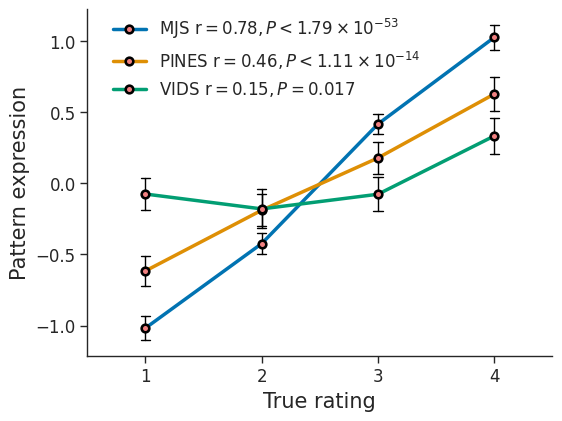

In [17]:
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_disc_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.75, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
                                r'$\mathrm{{PINES\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(pines_r, 2), str(pines_p)[0:4], str(pines_p)[-2:]),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(3))),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_study1.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.98
Accuracy SE:        0.12
Accuracy p-value:   0.00
Sensitivity:        1.00
Specificity:        1.00
AUC:                1.00
PPV:                1.00
------------------------
Cohen's d: 2.99


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.95
Accuracy SE:        0.12
Accuracy p-value:   0.00
Sensitivity:        0.94
Specificity:        0.94
AUC:                0.94
PPV:                0.94
------------------------
Cohen's d: 1.37


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.70
Accuracy SE:        0.09
Accuracy p-value:   0.00
Sensitivity:        0.72
Specificity:        0.72
AUC:                0.72
PPV:                0.72
------------------------
Cohen's d: 0.43




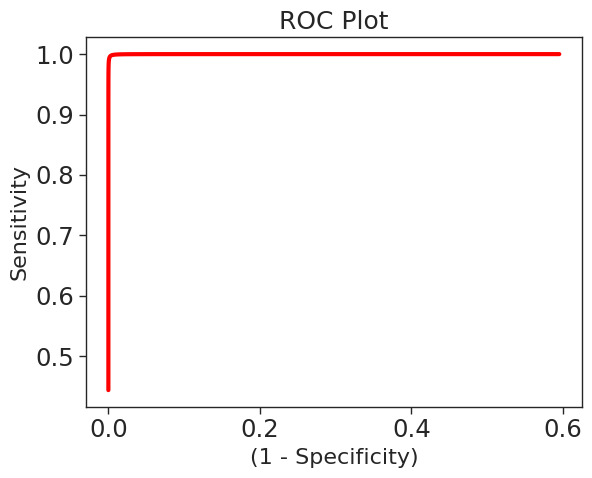

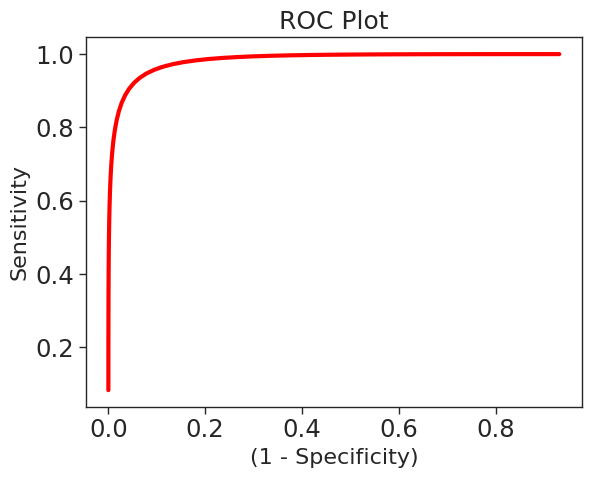

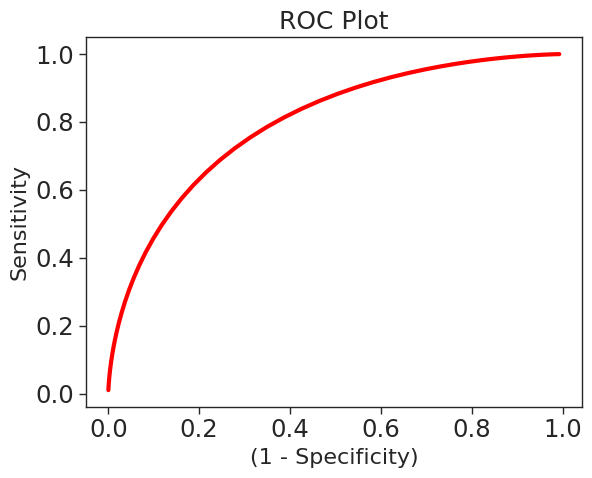

In [18]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_disc[df_disc['ratings'].isin([1,4])]
fc_data = fc_data.groupby(['subject','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==4 else False)
fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==4][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
## Validation Cohort

In [59]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x and 'sub-07' not in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

In [61]:
# Load betas and subtract subject means
valid_data = Brain_Data(betas).standardize(axis=1)
valid_data.X['subject'] = sub_info['subject']
valid_data.Y = sub_info['ratings']
subject_id = valid_data.X['subject']

In [62]:
# Fill dataframe to make sure that we have same number of observations for each subject even if NaNs (needed for force-choice tests)
df_valid = pd.DataFrame()
counter = 0
for sub in sub_info.subject.unique():
    for rating in range(1,5):
        df_valid.loc[counter, 'subject'] = sub
        df_valid.loc[counter, 'ratings'] = rating
        counter += 1

sub_info['MJS'] = zscore(pd.Series(valid_data.similarity(mjs, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(valid_data.similarity(pines, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(valid_data.similarity(vids, method='dot_product')))
df_valid = df_valid.merge(sub_info, on=['subject','ratings'], how='left')
# # df_valid.to_csv('results/sensitivity/valid_external_predictions.csv', index=False)

In [35]:
mjs_r, mjs_p = stats.pearsonr(df_valid.dropna()['ratings'] , df_valid.dropna()['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_valid['ratings'], df_valid['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(df_valid.dropna()['ratings'] , df_valid.dropna()['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_valid['ratings'], df_valid['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(df_valid.dropna()['ratings'] , df_valid.dropna()['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_valid['ratings'], df_valid['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.6 5.796042099468859e-13
MJS 95% CI: [0.486, 0.700]


PINES: Average overall (between- and within-subjects) correlation: r = 0.16 0.08110671358669228
PINES 95% CI: [-0.015, 0.327]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.05 0.5902577661521252
PINES 95% CI: [-0.129, 0.229]




In [87]:
print('MJS: ', within_person_correlation(df_valid.ratings, df_valid['MJS'], df_valid.subject))
print('PINES: ', within_person_correlation(df_valid.ratings, df_valid['PINES'], df_valid.subject))
print('VIDS: ', within_person_correlation(df_valid.ratings, df_valid['VIDS'], df_valid.subject))

MJS:  (0.9, 0.02)
PINES:  (0.41, 0.09)
VIDS:  (0.24, 0.1)


In [88]:
df_valid_long = df_valid.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

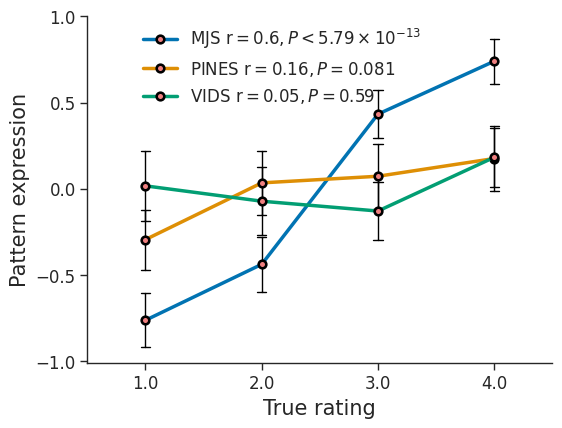

In [89]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_valid_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Make yticks range from -1 to 1 
plt.yticks(np.arange(-1, 1.5, 0.5))

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.75, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(3))),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(3))),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_study2.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           1.00
Accuracy SE:        0.19
Accuracy p-value:   0.00
Sensitivity:        1.00
Specificity:        1.00
AUC:                1.00
PPV:                1.00
------------------------
Cohen's d: 1.88


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.83
Accuracy SE:        0.15
Accuracy p-value:   0.00
Sensitivity:        0.78
Specificity:        0.78
AUC:                0.78
PPV:                0.78
------------------------
Cohen's d: 0.5


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.72
Accuracy SE:        0.13
Accuracy p-value:   0.02
Sensitivity:        0.68
Specificity:        0.68
AUC:                0.68
PPV:                0.68
------------------------
Cohen's d: 0.18




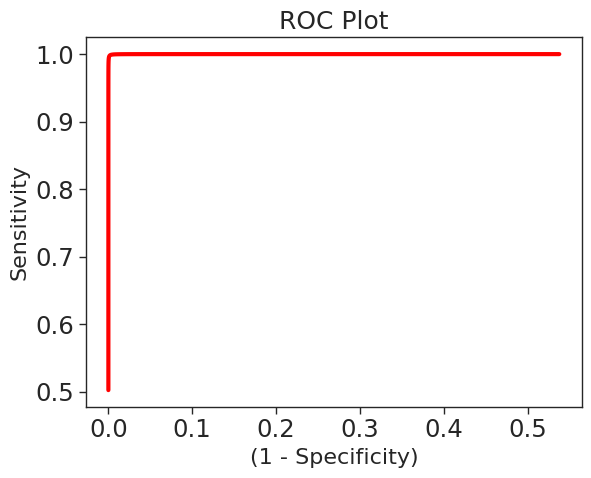

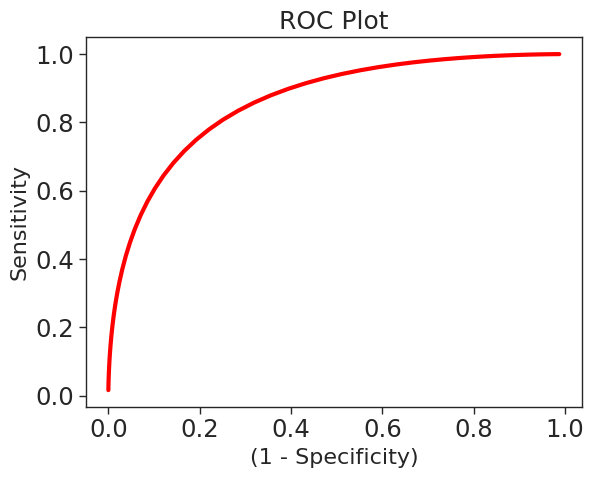

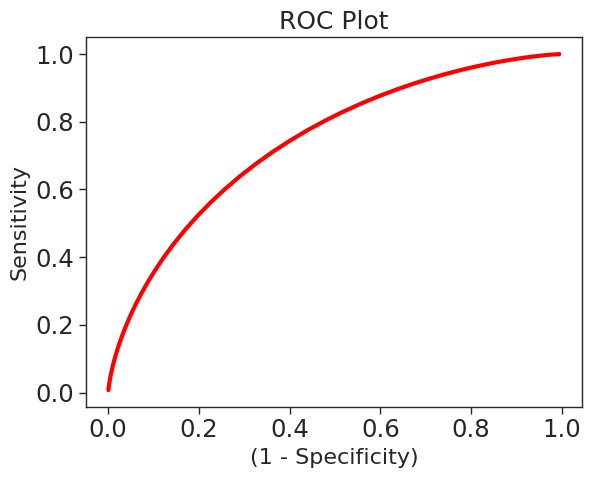

In [94]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_valid[df_valid['ratings'].isin([1,4])]
fc_data = fc_data.groupby(['subject','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==4 else False)
fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
# drop subjects with fewer than 2 values
fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==4][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
## Replication Cohort

In [96]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/duke/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 27 unique subjects
assert len(sub_info.subject.unique()) == 27

# We should have 108 beta maps
assert len(sub_info) == 27 * 4

In [97]:
# Load betas and take out subject means
repl_data = Brain_Data(betas).standardize(axis=1)
repl_data.X['subject'] = sub_info['subject']
repl_data.Y = sub_info['ratings']
subject_id = repl_data.X['subject']

In [98]:
df_repl = pd.DataFrame()
counter = 0
for sub in sub_info.subject.unique():
    for rating in range(1,5):
        df_repl.loc[counter, 'subject'] = sub
        df_repl.loc[counter, 'ratings'] = rating
        counter += 1

sub_info['MJS'] = zscore(pd.Series(repl_data.similarity(mjs, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(repl_data.similarity(pines, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(repl_data.similarity(vids, method='dot_product')))
df_repl = df_repl.merge(sub_info, on=['subject','ratings'], how='left')

In [99]:
mjs_r, mjs_p = stats.pearsonr(df_repl['ratings'] , df_repl['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_repl['ratings'], df_repl['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(df_repl['ratings'] ,df_repl['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_repl['ratings'], df_repl['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(df_repl['ratings'] ,df_repl['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_repl['ratings'], df_repl['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.49 7.355123318790073e-08
MJS 95% CI: [0.341, 0.623]


PINES: Average overall (between- and within-subjects) correlation: r = 0.32 0.0008379564106670488
PINES 95% CI: [0.133, 0.484]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.13 0.19295528278500498
PINES 95% CI: [-0.068, 0.325]




In [100]:
print('MJS: ', within_person_correlation(df_repl.ratings, df_repl['MJS'], df_repl.subject))
print('PINES: ', within_person_correlation(df_repl.ratings, df_repl['PINES'], df_repl.subject))
print('VIDS: ', within_person_correlation(df_repl.ratings, df_repl['VIDS'], df_repl.subject))

MJS:  (0.82, 0.07)
PINES:  (0.56, 0.1)
VIDS:  (0.38, 0.12)


In [102]:
df_repl_long = df_repl.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

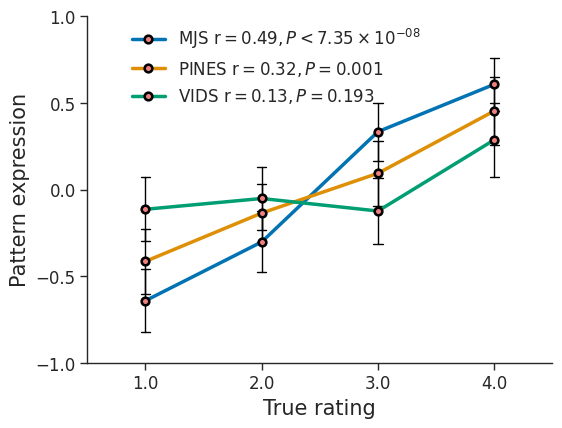

In [103]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_repl_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Make yticks range from -1 to 1 
plt.yticks(np.arange(-1, 1.5, 0.5))

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.75, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(3))),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(3))),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_study3.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.93
Accuracy SE:        0.18
Accuracy p-value:   0.00
Sensitivity:        0.96
Specificity:        0.96
AUC:                0.96
PPV:                0.96
------------------------
Cohen's d: 1.42


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.81
Accuracy SE:        0.16
Accuracy p-value:   0.00
Sensitivity:        0.84
Specificity:        0.84
AUC:                0.84
PPV:                0.84
------------------------
Cohen's d: 0.86


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.78
Accuracy SE:        0.15
Accuracy p-value:   0.01
Sensitivity:        0.76
Specificity:        0.76
AUC:                0.76
PPV:                0.76
------------------------
Cohen's d: 0.38




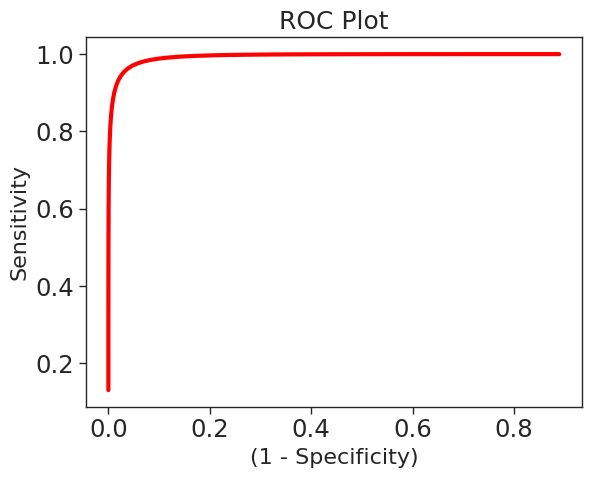

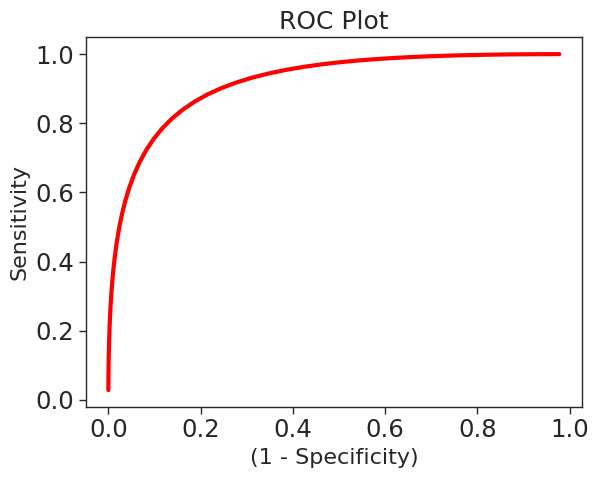

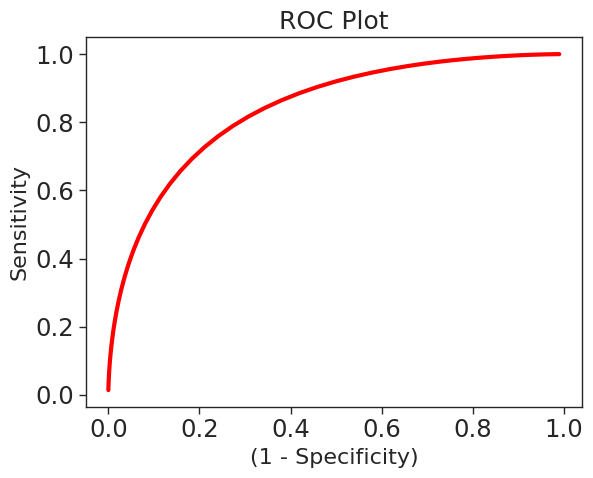

In [104]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_repl[df_repl['ratings'].isin([1,4])]
fc_data = fc_data.groupby(['subject','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==4 else False)
fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
# drop subjects with fewer than 2 values
fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==4][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
## Generalization

In [105]:
betas_dir = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/uva/'

betas = [x for x in glob.glob(betas_dir+'sub*') if 'common' in x and 'scaled' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([int(x.split('/')[-1].split('_')[0].split('-')[1]) for x in betas])
sub_info['ratings'] = pd.Series([int(x.split('/')[-1].split('_')[4]) for x in betas])

# We should have 30 unique subjects
assert len(sub_info.subject.unique()) == 30

# We should have 120 beta maps
assert len(sub_info) == 30 * 4

In [106]:
# Load betas and take out subject means
gen_data = Brain_Data(betas).standardize(axis=1)
gen_data.X['subject'] = sub_info['subject']
gen_data.Y = sub_info['ratings']
subject_id = gen_data.X['subject']

In [107]:
df_gen = pd.DataFrame()
counter = 0
for sub in sub_info.subject.unique():
    for rating in range(1,5):
        df_gen.loc[counter, 'subject'] = sub
        df_gen.loc[counter, 'ratings'] = rating
        counter += 1

sub_info['MJS'] = zscore(pd.Series(gen_data.similarity(mjs, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(gen_data.similarity(pines, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(gen_data.similarity(vids, method='dot_product')))
# df_repl.to_csv('results/sensitivity/repl_external_predictions.csv', index=False)
df_gen = df_gen.merge(sub_info, on=['subject','ratings'], how='left')

In [108]:
mjs_r, mjs_p = stats.pearsonr(df_gen['ratings'] , df_gen['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_gen['ratings'], df_gen['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(df_gen['ratings'] ,df_gen['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_gen['ratings'], df_gen['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(df_gen['ratings'] ,df_gen['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_gen['ratings'], df_gen['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.42 1.8520614146948032e-06
MJS 95% CI: [0.275, 0.546]


PINES: Average overall (between- and within-subjects) correlation: r = 0.22 0.01694771974363597
PINES 95% CI: [0.040, 0.388]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.12 0.20268371348887915
PINES 95% CI: [-0.069, 0.296]




In [109]:
print('MJS: ', within_person_correlation(df_gen.ratings, df_gen['MJS'], df_gen.subject))
print('PINES: ', within_person_correlation(df_gen.ratings, df_gen['PINES'], df_gen.subject))
print('VIDS: ', within_person_correlation(df_gen.ratings, df_gen['VIDS'], df_gen.subject))

MJS:  (0.91, 0.02)
PINES:  (0.69, 0.07)
VIDS:  (0.25, 0.12)


In [110]:
df_gen_long = df_gen.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

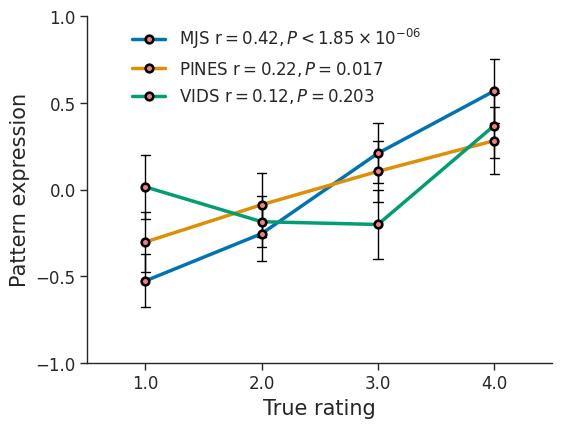

In [111]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_gen_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Make yticks range from -1 to 1 
plt.yticks(np.arange(-1, 1.5, 0.5))

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.75, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(mjs_r, 2), str(mjs_p)[0:4], str(mjs_p)[-2:]),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(3))),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(3))),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_study4.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           1.00
Accuracy SE:        0.18
Accuracy p-value:   0.00
Sensitivity:        0.98
Specificity:        0.98
AUC:                0.98
PPV:                0.98
------------------------
Cohen's d: 1.17


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.93
Accuracy SE:        0.17
Accuracy p-value:   0.00
Sensitivity:        0.88
Specificity:        0.88
AUC:                0.88
PPV:                0.88
------------------------
Cohen's d: 0.58


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.70
Accuracy SE:        0.13
Accuracy p-value:   0.04
Sensitivity:        0.66
Specificity:        0.66
AUC:                0.66
PPV:                0.66
------------------------
Cohen's d: 0.35




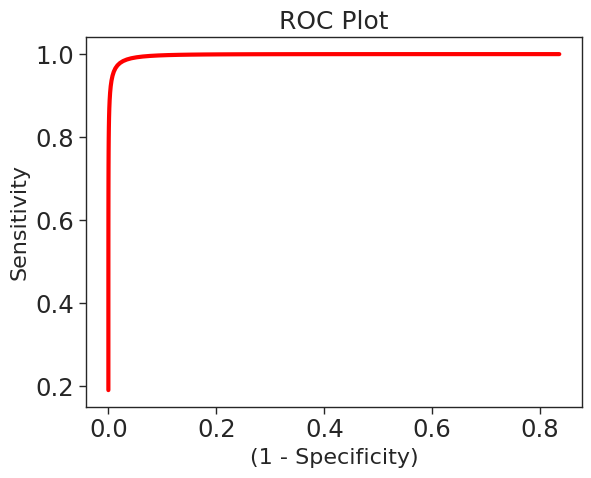

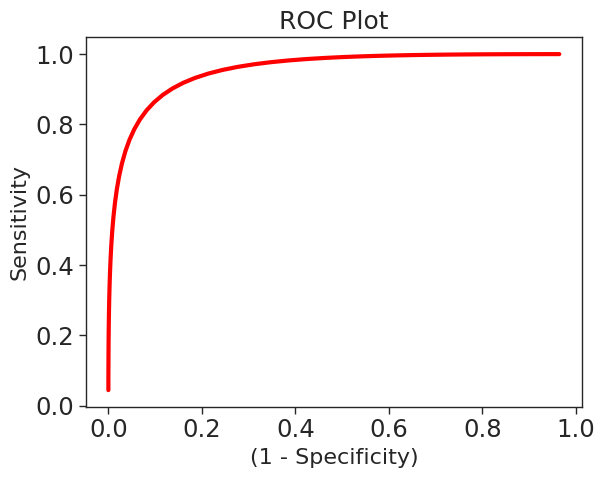

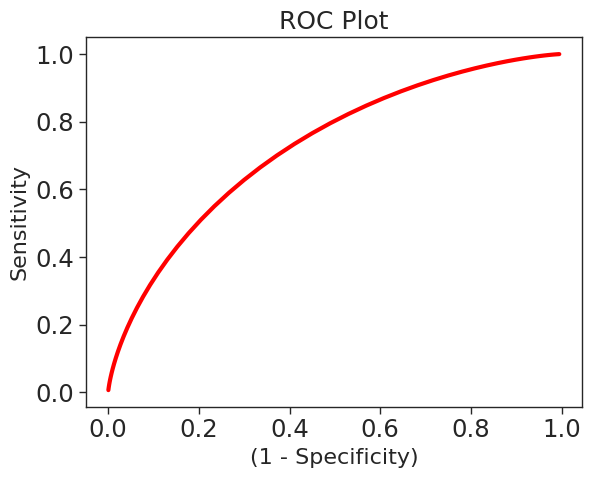

In [112]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_gen[df_gen['ratings'].isin([1,4])]
fc_data = fc_data.groupby(['subject','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==4 else False)
fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
# drop subjects with fewer than 2 values
fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==4][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
# PINES Data

In [113]:
# parse metadata
pines_meta = glob.glob("/srv/lab/fmri/pines/neurovault/collection_1964/image*.json")
sub_info = pd.DataFrame()
for i, f in enumerate(pines_meta):
    js = json.load(open(f, 'r'))
    sub_info.loc[i, 'SubjectID'] = js['SubjectID']
    sub_info.loc[i, 'Holdout'] = js['Holdout']
    sub_info.loc[i, 'Rating'] = js['Rating']
    sub_info.loc[i, 'file'] = f.replace('_metadata.json', '.nii.gz')

sub_info = sub_info[sub_info['Holdout']=="Test"]
sub_info = sub_info.reset_index()

# load brain data
pines_data = Brain_Data(sub_info['file'].to_list()).standardize(axis=1)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [114]:
df_pines = pd.DataFrame()
counter = 0
for sub in sub_info['SubjectID'].unique():
    for rating in range(1,6):
        df_pines.loc[counter, 'SubjectID'] = sub
        df_pines.loc[counter, 'Rating'] = rating
        counter += 1

sub_info['MJS'] = zscore(pd.Series(pines_data.similarity(mjs, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(pines_data.similarity(pines, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(pines_data.similarity(vids, method='dot_product')))
# df_repl.to_csv('results/sensitivity/repl_external_predictions.csv', index=False)
df_pines = df_pines.merge(sub_info, on=['SubjectID','Rating'], how='left')
# rename Rating to ratings
df_pines.rename(columns={'Rating': 'ratings'}, inplace=True)

In [117]:
mjs_r, mjs_p = stats.pearsonr(df_pines.dropna()['ratings'] , df_pines.dropna()['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_pines['ratings'], df_pines['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(df_pines.dropna()['ratings'] , df_pines.dropna()['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_pines['ratings'], df_pines['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(df_pines.dropna()['ratings'] , df_pines.dropna()['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_pines['ratings'], df_pines['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.04 0.5497622887880645
MJS 95% CI: [-0.082, 0.154]


PINES: Average overall (between- and within-subjects) correlation: r = 0.72 9.028326529969146e-45
PINES 95% CI: [0.658, 0.769]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.26 7.859248212112035e-06
PINES 95% CI: [0.157, 0.370]




In [119]:
print('MJS: ', within_person_correlation(df_pines.ratings, df_pines['MJS'], df_pines.SubjectID))
print('PINES: ', within_person_correlation(df_pines.ratings, df_pines['PINES'], df_pines.SubjectID))
print('VIDS: ', within_person_correlation(df_pines.ratings, df_pines['VIDS'], df_pines.SubjectID))

MJS:  (0.02, 0.08)
PINES:  (0.92, 0.01)
VIDS:  (0.51, 0.06)


In [120]:
df_pines_long = df_pines.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

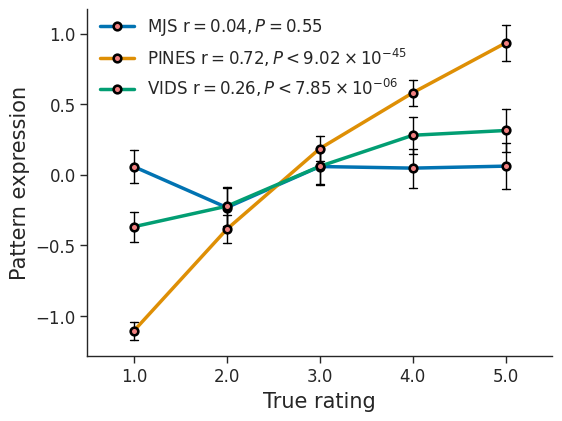

In [122]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_pines_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Make yticks range from -1 to 1 
plt.yticks(np.arange(-1, 1.5, 0.5))

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.72, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P = {}$'.format(round(mjs_r, 2), str(mjs_p.round(3))),
                                r'$\mathrm{{PINES\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(pines_r, 2), str(pines_p)[0:4], str(pines_p)[-2:]),
                                r'$\mathrm{{VIDS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(vids_r, 2), str(vids_p)[0:4], str(vids_p)[-2:]),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_PINES.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.49
Accuracy SE:        0.07
Accuracy p-value:   1.00
Sensitivity:        0.53
Specificity:        0.53
AUC:                0.53
PPV:                0.53
------------------------
Cohen's d: 0.06


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           1.00
Accuracy SE:        0.15
Accuracy p-value:   0.00
Sensitivity:        1.00
Specificity:        1.00
AUC:                1.00
PPV:                1.00
------------------------
Cohen's d: 2.88


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.79
Accuracy SE:        0.11
Accuracy p-value:   0.00
Sensitivity:        0.78
Specificity:        0.78
AUC:                0.78
PPV:                0.78
------------------------
Cohen's d: 0.69




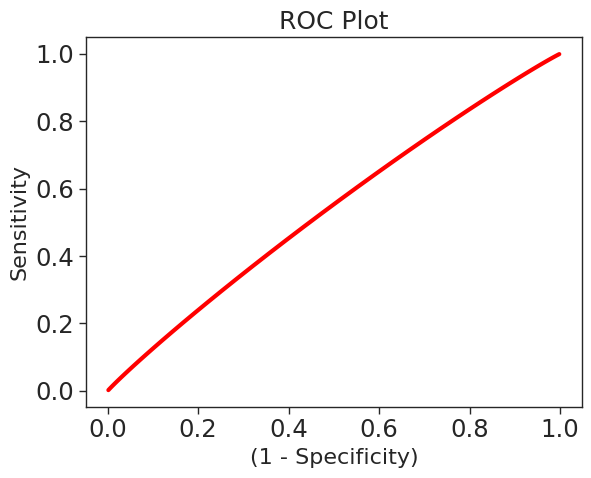

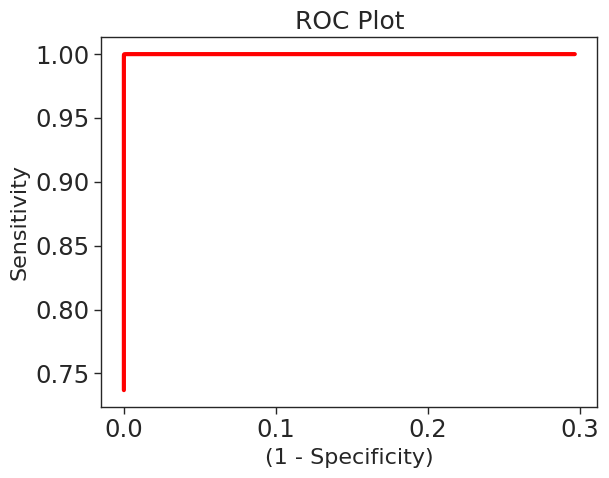

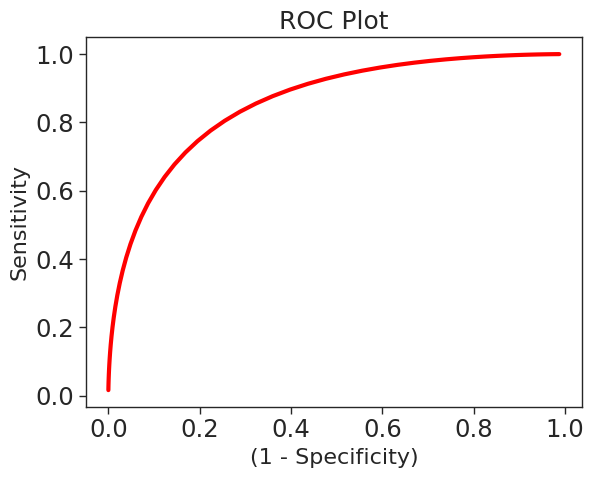

In [131]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_pines[df_pines['ratings'].isin([1,5])]
fc_data = fc_data.groupby(['SubjectID','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==5 else False)
fc_data['sub_ix'] = fc_data['SubjectID'].astype('category').cat.codes
# drop subjects with fewer than 2 values
fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==5][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
# VIDS Data

In [134]:
df_vids = pd.read_csv("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/disgust_predictions.csv")
df_vids['condition'] = df_vids['rating'].map(cond_map)

df_vids['PINES'] = zscore(df_vids['PINES'])
df_vids['VIDS'] = zscore(df_vids['VIDS'])
df_vids['MJS'] = zscore(df_vids['MJS'])

df_vids.rename(columns={'rating': 'ratings'}, inplace=True)

In [135]:
mjs_r, mjs_p = stats.pearsonr(df_vids.dropna()['ratings'] , df_vids.dropna()['MJS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_vids['ratings'], df_vids['MJS'])
print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f"MJS 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
# print newline
print("\n")

pines_r, pines_p = stats.pearsonr(df_vids.dropna()['ratings'] , df_vids.dropna()['PINES'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_vids['ratings'], df_vids['PINES'])
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

vids_r, vids_p = stats.pearsonr(df_vids.dropna()['ratings'] , df_vids.dropna()['VIDS'])
corr, (ci_lower, ci_upper), boot_corrs = bootstrap_pearsonr_ci(df_vids['ratings'], df_vids['VIDS'])
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)
print(f"PINES 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print("\n")

MJS: Average overall (between- and within-subjects) correlation: r = 0.03 0.7536116235698251
MJS 95% CI: [-0.132, 0.180]


PINES: Average overall (between- and within-subjects) correlation: r = 0.3 0.00018408239543358384
PINES 95% CI: [0.152, 0.445]


VIDS: Average overall (between- and within-subjects) correlation: r = 0.62 1.6486678118521435e-17
PINES 95% CI: [0.536, 0.705]




In [137]:
print('MJS: ', within_person_correlation(df_vids.ratings, df_vids['MJS'], df_vids.subject))
print('PINES: ', within_person_correlation(df_vids.ratings, df_vids['PINES'], df_vids.subject))
print('VIDS: ', within_person_correlation(df_vids.ratings, df_vids['VIDS'], df_vids.subject))

MJS:  (0.07, 0.12)
PINES:  (0.5, 0.08)
VIDS:  (0.89, 0.03)


In [139]:
df_disgust_long = df_vids.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings', 
                                          var_name='model', value_name='pexp')

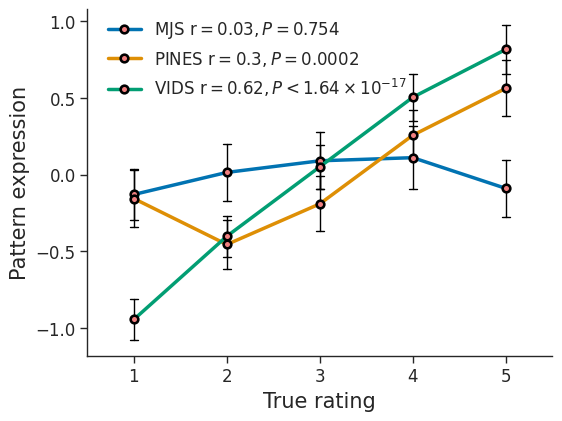

In [140]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=df_disgust_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Make yticks range from -1 to 1 
# plt.yticks(np.arange(-1, 1.5, 0.5))

# Add text to the legend labels

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.72, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P = {}$'.format(round(mjs_r, 2), str(mjs_p.round(3))),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(4))),
                                r'$\mathrm{{VIDS\ r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(vids_r, 2), str(vids_p)[0:4], str(vids_p)[-2:]),
                               )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_VIDS.png', dpi=300, bbox_inches='tight')
plt.show()

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.52
Accuracy SE:        0.10
Accuracy p-value:   1.00
Sensitivity:        0.54
Specificity:        0.54
AUC:                0.54
PPV:                0.54
------------------------
Cohen's d: 0.08


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.76
Accuracy SE:        0.14
Accuracy p-value:   0.01
Sensitivity:        0.76
Specificity:        0.76
AUC:                0.76
PPV:                0.76
------------------------
Cohen's d: 0.7


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           1.00
Accuracy SE:        0.19
Accuracy p-value:   0.00
Sensitivity:        0.99
Specificity:        0.99
AUC:                0.99
PPV:                0.99
------------------------
Cohen's d: 2.19




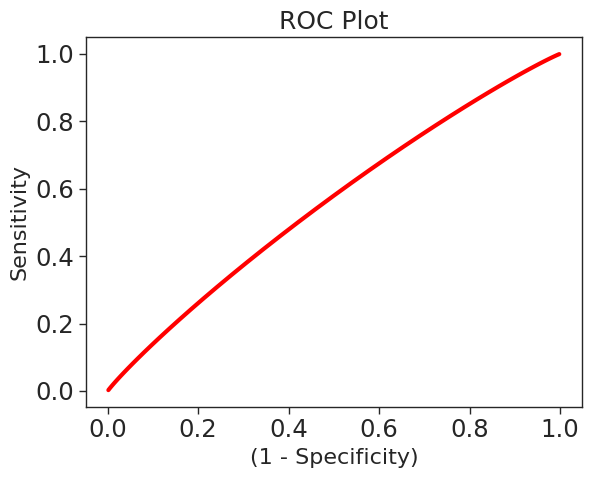

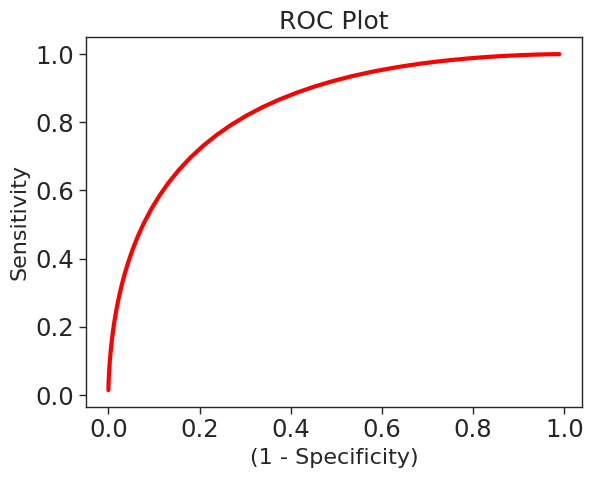

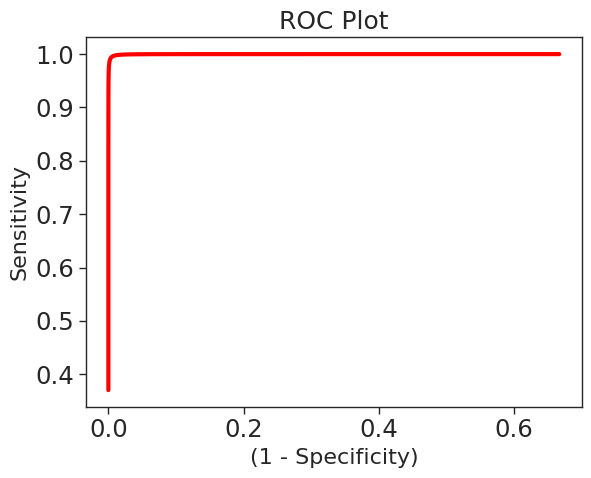

In [143]:
# Prepare data and run forced-choice test for 1 vs. 4
fc_data = df_vids[df_vids['ratings'].isin([1,5])]
fc_data = fc_data.groupby(['subject','ratings'])[['PINES','MJS','VIDS']].mean().reset_index()
fc_data = fc_data.dropna()
fc_data['cond_bool'] = fc_data['ratings'].apply(lambda x: True if x==5 else False)
fc_data['sub_ix'] = fc_data['subject'].astype('category').cat.codes
# drop subjects with fewer than 2 values
fc_data = fc_data.groupby('sub_ix').filter(lambda x: len(x) > 1)

for model in ['MJS', 'PINES', 'VIDS']:
    print('MODEL', model)
    # print line break
    roc = Roc(input_values=np.array(fc_data[model].values),
            binary_outcome=np.array(fc_data['cond_bool'].values), 
            forced_choice=np.array(fc_data['sub_ix'].values))
    roc.plot()
    roc.summary()
    c0 = fc_data[fc_data['ratings']==5][model]
    c1 = fc_data[fc_data['ratings']==1][model]

    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    print("Cohen's d:", round(cohens_d, 2))
    print('\n')

***
## Intention vs. Accidents

In [3]:
subjects = pd.read_csv("/srv/lab/fmri/mft/intention/participants.tsv", sep='\t')
print(subjects.gender.value_counts())
print(subjects['age'].describe())

subjects['subject'] = subjects['participant_id']

gender
M    29
F    10
Name: count, dtype: int64
count    39.000000
mean     30.333333
std       9.268888
min      19.000000
25%      22.000000
50%      28.000000
75%      37.500000
max      50.000000
Name: age, dtype: float64


In [4]:
subjects['group'].value_counts()

group
NT     25
ASD    14
Name: count, dtype: int64

In [5]:
subjects[subjects['group']=='NT'].age.describe()

count    25.000000
mean     28.640000
std       9.720597
min      19.000000
25%      21.000000
50%      24.000000
75%      36.000000
max      50.000000
Name: age, dtype: float64

In [6]:
subjects[subjects['group']=='NT'].gender.value_counts()

gender
M    17
F     8
Name: count, dtype: int64

In [7]:
subjects[subjects['group']=='ASD'].age.describe()

count    14.000000
mean     33.357143
std       7.830975
min      21.000000
25%      27.500000
50%      33.000000
75%      37.750000
max      46.000000
Name: age, dtype: float64

In [8]:
subjects[subjects['group']=='ASD'].gender.value_counts()

gender
M    12
F     2
Name: count, dtype: int64

In [ ]:
moral_mapper = { "A_PHA": "physical harms", 
        "B_PSA":  "psychological harms",
        "C_IA":  "incest violations",
        "D_PA":  "pathogen violations",
        "E_NA":  "neutral scenarios",
        "F_PHI":  "physical harms",
        "G_PSI":  "psychological harms",
        "H_II":  "incest violations",
        "I_PI":  "pathogen violations",
        "J_NI":  "neutral scenarios"
}

int_mapper = {'intention': ["F_PHI", "G_PSI", "H_II", "I_PI", "J_NI"],
              'accidental': ["A_PHA", "B_PSA", "C_IA", "D_PA", "E_NA"]}

In [ ]:
int_betas = [x for x in glob.glob("/srv/lab/fmri/mft/intention/derivatives/glm/*") if 'whole-trial' not in x]
int_betas.sort()

sub_info = pd.DataFrame()
for f in int_betas:
    sub_info.loc[len(sub_info), 'subject'] = 'sub-'+f.split('/')[-1].split('_')[0].split('-')[1]
    sub_info.loc[len(sub_info)-1, 'cond'] = '_'.join(f.split('/')[-1].split('_')[1:3])
    sub_info.loc[len(sub_info)-1, 'file'] = f

sub_info = sub_info.merge(subjects[['subject', 'group']], on='subject', how='left')

sub_info['sub_ix'] = sub_info['subject'].astype('category').cat.codes
sub_info['intention'] = sub_info['cond'].map(lambda x: "intention" if x in int_mapper['intention'] else "accident")
sub_info['domain'] = sub_info['cond'].map(lambda x: moral_mapper[x])

assert len(sub_info['subject'].unique()) == 39

int_brain = Brain_Data(int_betas).standardize(axis=1)

In [ ]:
sub_info['MJS'] = zscore(pd.Series(int_brain.similarity(mjs, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(int_brain.similarity(vids, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(int_brain.similarity(pines, method='dot_product')))

sub_info_long = sub_info.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars=['intention', 'domain', 'subject', 'group'], value_name='Pattern expression', var_name='Model')
sub_info_long_moral = sub_info_long[sub_info_long['domain'] != 'neutral scenarios']

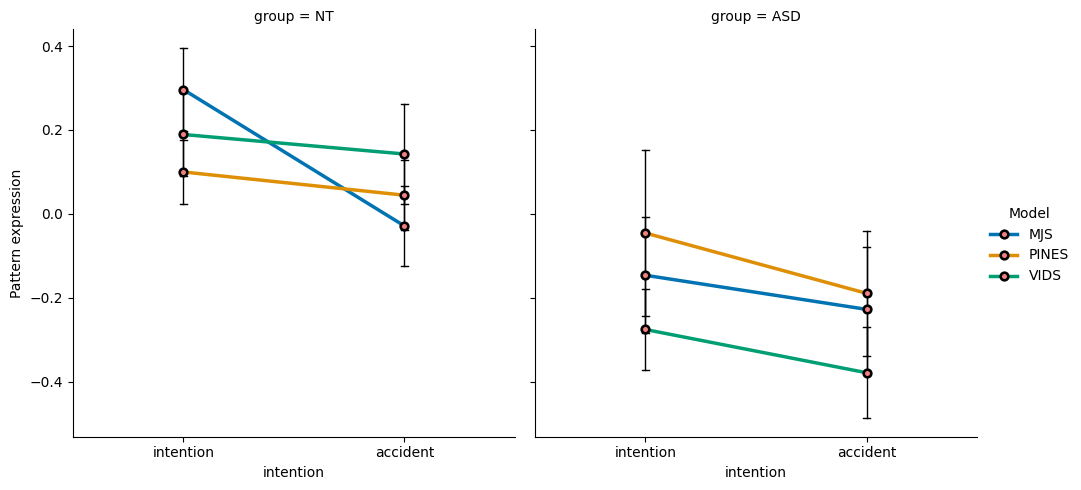

In [ ]:
sns.catplot(x='intention', y='Pattern expression', data=sub_info_long_moral, hue='Model', errorbar='se', col='group', kind='point', palette="colorblind", err_kws={'color':"black", 'linewidth': 1, "zorder":-1},**{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5}, 
linewidth=2.5, capsize=0.03, order = ['intention', 'accident'])
sns.despine()
# Change y label
plt.ylabel('Pattern expression',fontsize=15)
# save plot
plt.savefig('../../plots/intention_external_comparisons.png', dpi=300, bbox_inches='tight')

In [ ]:
int_acc = sub_info[sub_info['domain'] != 'neutral scenarios'].copy()
del int_acc['file']
del int_acc['cond']
del int_acc['domain']
int_acc = int_acc.groupby(['subject', 'intention', 'group']).mean().reset_index()
int_acc['cond_bool'] = int_acc['intention'].apply(lambda x: True if x == 'intention' else False)

GROUP: NT


MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.76
Accuracy SE:        0.15
Accuracy p-value:   0.01
Sensitivity:        0.73
Specificity:        0.73
AUC:                0.73
PPV:                0.73
------------------------
Cohen's d: 0.43


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.60
Accuracy SE:        0.12
Accuracy p-value:   0.42
Sensitivity:        0.54
Specificity:        0.54
AUC:                0.54
PPV:                0.54
------------------------
Cohen's d: 0.09


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.36
Accuracy SE:        0.07
Accuracy p-value:   0.23
Sensitivity:        0.53
Specificity:        0.53
AUC:                0.53
PPV:                0.53
------------------------
Cohen's d: 0.05


GROUP: ASD


MODEL MJS


------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.50
Accuracy SE:        0.13
Accuracy p-value:   1.00
Sensitivity:        0.57
Specificity:        0.57
AUC:                0.57
PPV:                0.57
------------------------
Cohen's d: 0.09


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.57
Accuracy SE:        0.15
Accuracy p-value:   0.79
Sensitivity:        0.61
Specificity:        0.61
AUC:                0.61
PPV:                0.61
------------------------
Cohen's d: 0.13


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.57
Accuracy SE:        0.15
Accuracy p-value:   0.79
Sensitivity:        0.59
Specificity:        0.59
AUC:                0.59
PPV:                0.59
------------------------
Cohen's d: 0.17




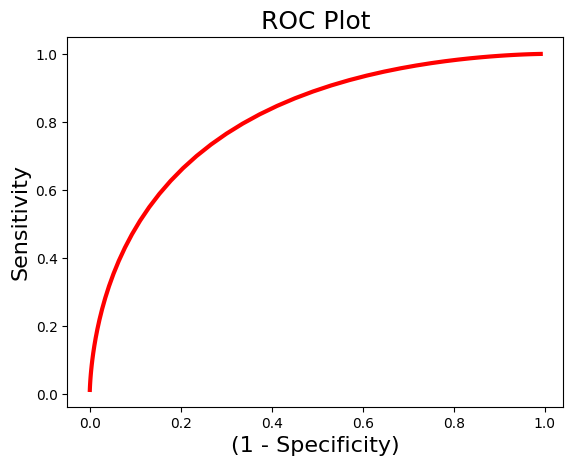

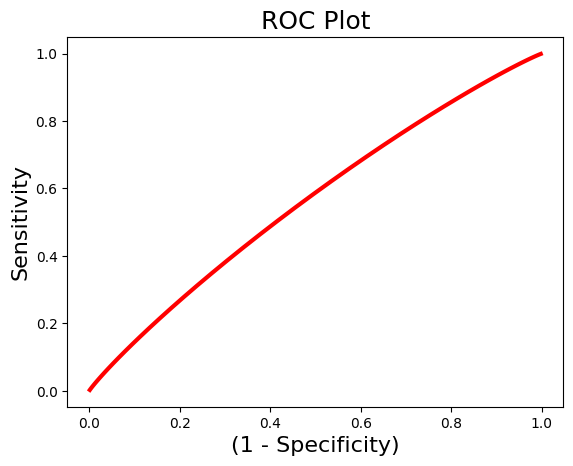

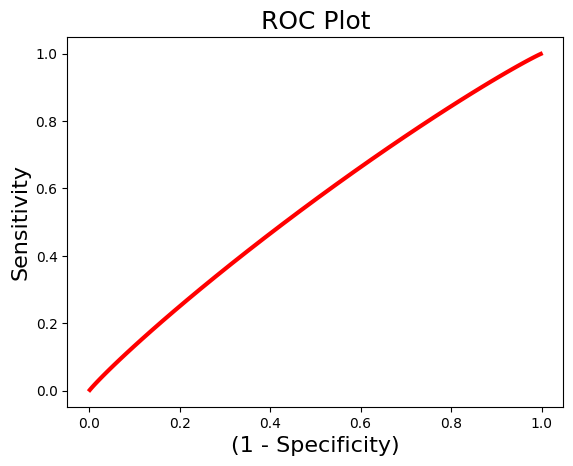

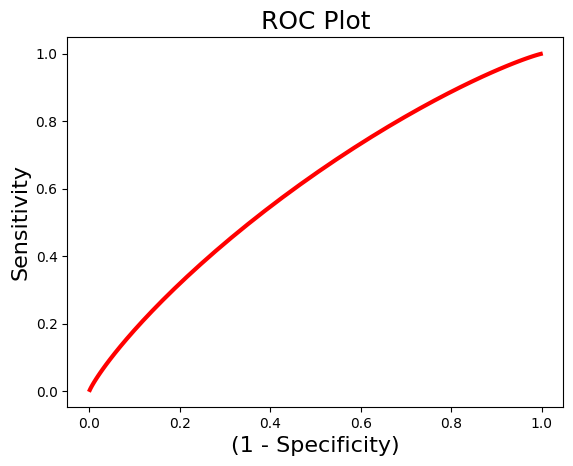

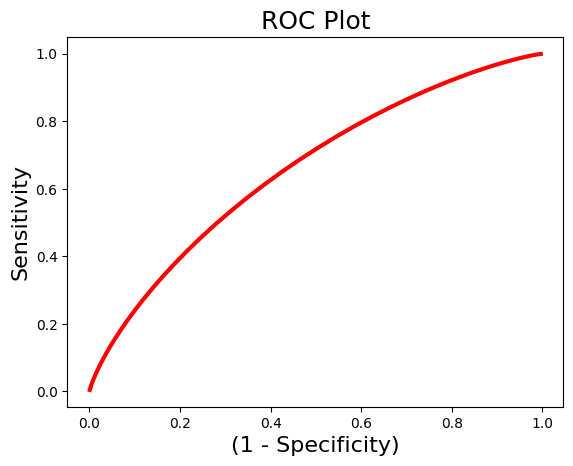

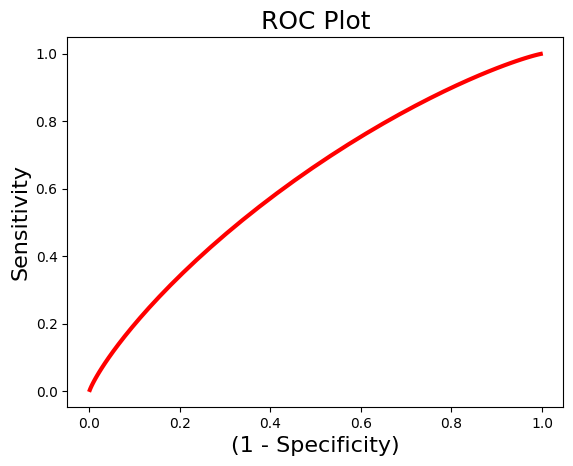

In [ ]:
for group in ['NT', 'ASD']:
    print('GROUP:', group)
    # print line break
    print('\n')
    for model in ['MJS', 'PINES','VIDS']:
        sel_group = int_acc[(int_acc['group'] == group)]
        print('MODEL', model)
        roc = Roc(input_values=np.array(sel_group[model].values),
                binary_outcome=np.array(sel_group['cond_bool'].values), 
                forced_choice=np.array(sel_group['sub_ix'].values))
        roc.plot()
        roc.summary()
        c0 = sel_group[sel_group['intention']=='intention'][model]
        c1 = sel_group[sel_group['intention']=='accident'][model]

        cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
        print("Cohen's d:", round(cohens_d, 2))
        print('\n')

***
## Visual Scenes 1

In [3]:
smid1_files = glob.glob("/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/*smid*")
smid1_files.sort()

sub_info = pd.DataFrame()
for f in smid1_files:
    sub_info.loc[len(sub_info), 'file'] = f
    sub_info.loc[len(sub_info)-1, 'subject'] = int(f.split('/')[-1].split('_')[0].split('-')[1])
    sub_info.loc[len(sub_info)-1, 'ratings'] = int(f.split('/')[-1].split('_')[2][-1])

sub_info['sub_ix'] = sub_info['subject'].astype('category').cat.codes
# smid1_brain = Brain_Data(smid1_files).standardize(axis=1)

print(len(sub_info.subject.unique()))

29


In [5]:
sub_info.subject.unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 18., 19., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 32., 33.])

In [4]:
sub_info

,file,subject,ratings,sub_ix
0,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,2.0,1.0,0
1,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,2.0,2.0,0
2,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,2.0,3.0,0
3,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,2.0,4.0,0
4,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,2.0,5.0,0
...,...,...,...,...
138,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,33.0,1.0,28
139,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,33.0,2.0,28
140,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,33.0,3.0,28
141,/srv/lab/fmri/mft/fhopp_diss/analysis/signatur...,33.0,4.0,28


In [4]:
sub_info['MJS'] = zscore(pd.Series(smid1_brain.similarity(mjs, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(smid1_brain.similarity(vids, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(smid1_brain.similarity(pines, method='dot_product')))

In [5]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , sub_info['MJS'])
pines_r, pines_p = stats.pearsonr(sub_info['ratings'] , sub_info['PINES'])
vids_r, vids_p = stats.pearsonr(sub_info['ratings'] , sub_info['VIDS'])

print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)

MJS: Average overall (between- and within-subjects) correlation: r = 0.15 0.08045582841490645
PINES: Average overall (between- and within-subjects) correlation: r = -0.06 0.49259070757035317
VIDS: Average overall (between- and within-subjects) correlation: r = 0.04 0.6431382897766279


In [11]:
per_subject_ratings = [x.values for x in np.array_split(sub_info['ratings'] , len(sub_info['subject'].unique()))]
per_subject_predictions = [x for x in np.array_split(sub_info['MJS'], len(sub_info['subject'].unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    # within_rmse.append(root_mean_squared_error(true, pred))

print(f'MJS: Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(stats.sem(within_r), 2)} (standard error (SE))')
# print(f'MJS: Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(stats.sem(within_rmse), 2)} (standard error (SE))')

per_subject_predictions = [x for x in np.array_split(sub_info['PINES'], len(sub_info['subject'].unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    # within_rmse.append(root_mean_squared_error(true, pred))

print(f'PINES: Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(stats.sem(within_r), 2)} (standard error (SE))')
# print(f'PINES: Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(stats.sem(within_rmse), 2)} (standard error (SE))')

per_subject_predictions = [x for x in np.array_split(sub_info['VIDS'], len(sub_info['subject'].unique()))]

within_r = []
within_rmse = []
for true, pred in zip(per_subject_ratings, per_subject_predictions):
    within_r.append(np.corrcoef(true, pred)[1][0])
    # within_rmse.append(root_mean_squared_error(true, pred))

print(f'VIDS: Average within-subject correlation: r = {round(np.mean(within_r), 2)} ± {round(stats.sem(within_r), 2)} (standard error (SE))')
# print(f'VIDS: Average RMSE: {round(np.mean(within_rmse), 2)} ± {round(stats.sem(within_rmse), 2)} (standard error (SE))')

MJS: Average within-subject correlation: r = 0.39 ± 0.1 (standard error (SE))
PINES: Average within-subject correlation: r = -0.16 ± 0.11 (standard error (SE))
VIDS: Average within-subject correlation: r = 0.07 ± 0.1 (standard error (SE))


In [12]:
smid1_long = sub_info.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings',
                                          var_name='model', value_name='pexp')

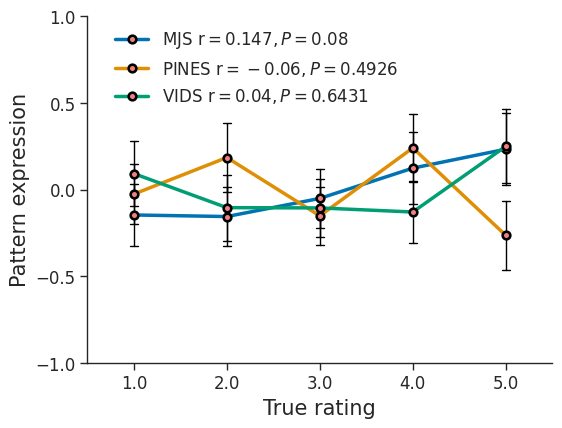

In [18]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=smid1_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.yticks(np.arange(-1, 1.5, 0.5))

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.7, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P = {}$'.format(round(mjs_r, 3), str(mjs_p.round(3))),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(4))),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(4))), 
                                )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/smid1_mjs_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
cond_mapper = {1:'moral', 
               2:'moral',
               3:'neutral',
               4:'immoral',
               5:'immoral'}

sub_info['cond'] = sub_info['ratings'].map(cond_mapper)

In [29]:
smid1_moral_immoral = sub_info[sub_info['cond'].isin(['moral','immoral'])]
smid1_moral_immoral = smid1_moral_immoral.groupby(['subject','cond'])[['MJS','PINES','VIDS']].mean().reset_index()
smid1_moral_immoral['cond_bool'] = smid1_moral_immoral['cond'].apply(lambda x: True if x=='immoral' else False)
smid1_moral_immoral['sub_ix'] = smid1_moral_immoral['subject'].astype('category').cat.codes

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.83
Accuracy SE:        0.15
Accuracy p-value:   0.00
Sensitivity:        0.78
Specificity:        0.78
AUC:                0.78
PPV:                0.78
------------------------
Cohen's d: 0.34


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.41
Accuracy SE:        0.08
Accuracy p-value:   0.46
Sensitivity:        0.43
Specificity:        0.43
AUC:                0.43
PPV:                0.43
------------------------
Cohen's d: -0.09


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.55
Accuracy SE:        0.10
Accuracy p-value:   0.71
Sensitivity:        0.54
Specificity:        0.54
AUC:                0.54
PPV:                0.54
------------------------
Cohen's d: 0.06




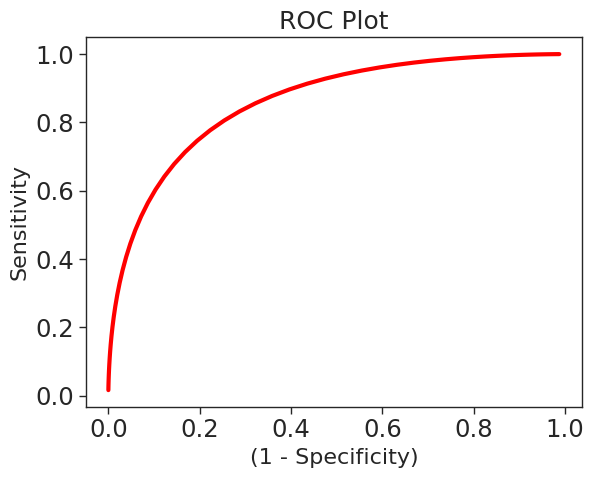

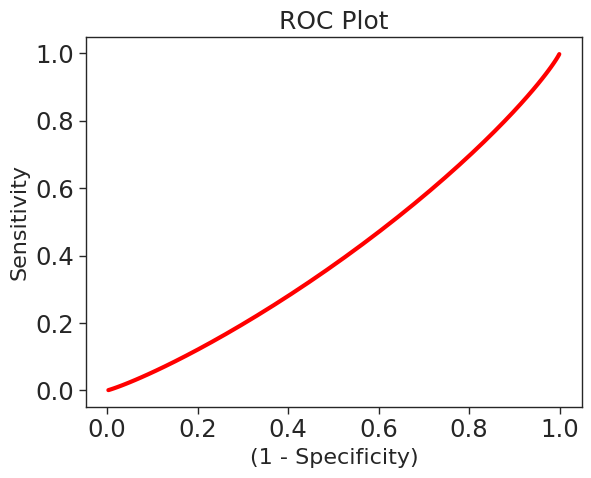

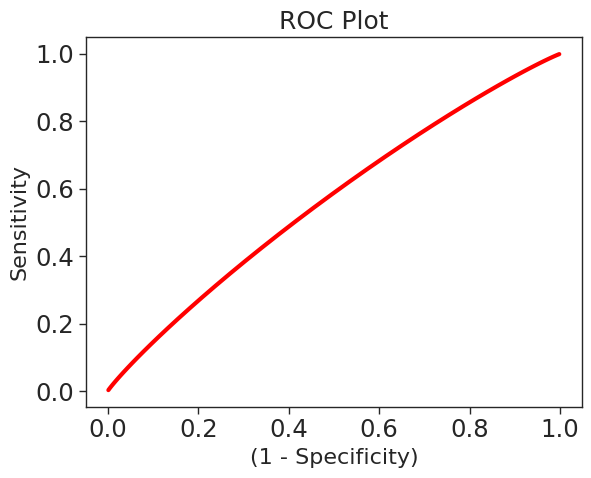

In [30]:
for model in ['MJS', 'PINES','VIDS']:
        print('MODEL', model)
        roc = Roc(input_values=np.array(smid1_moral_immoral[model].values),
                binary_outcome=np.array(smid1_moral_immoral['cond_bool'].values), 
                forced_choice=np.array(smid1_moral_immoral['sub_ix'].values))
        roc.plot()
        roc.summary()
        c0 = smid1_moral_immoral[smid1_moral_immoral['cond_bool']==True][model]
        c1 = smid1_moral_immoral[smid1_moral_immoral['cond_bool']==False][model]

        cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
        print("Cohen's d:", round(cohens_d, 2))
        print('\n')

In [35]:
smid1_moral_neutral = sub_info[sub_info['cond'].isin(['moral','neutral'])]
smid1_moral_neutral = smid1_moral_neutral.groupby(['subject','cond'])[['MJS','PINES','VIDS']].mean().reset_index()
smid1_moral_neutral['cond_bool'] = smid1_moral_neutral['cond'].apply(lambda x: True if x=='neutral' else False)
smid1_moral_neutral['sub_ix'] = smid1_moral_neutral['subject'].astype('category').cat.codes
smid1_moral_neutral = smid1_moral_neutral[smid1_moral_neutral['sub_ix']!=22]

MODEL MJS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.61
Accuracy SE:        0.11
Accuracy p-value:   0.34
Sensitivity:        0.59
Specificity:        0.59
AUC:                0.59
PPV:                0.59
------------------------
Cohen's d: 0.07


MODEL PINES
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.39
Accuracy SE:        0.07
Accuracy p-value:   0.34
Sensitivity:        0.31
Specificity:        0.31
AUC:                0.31
PPV:                0.31
------------------------
Cohen's d: -0.21


MODEL VIDS
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.46
Accuracy SE:        0.09
Accuracy p-value:   0.85
Sensitivity:        0.44
Specificity:        0.44
AUC:                0.44
PPV:                0.44
------------------------
Cohen's d: -0.07




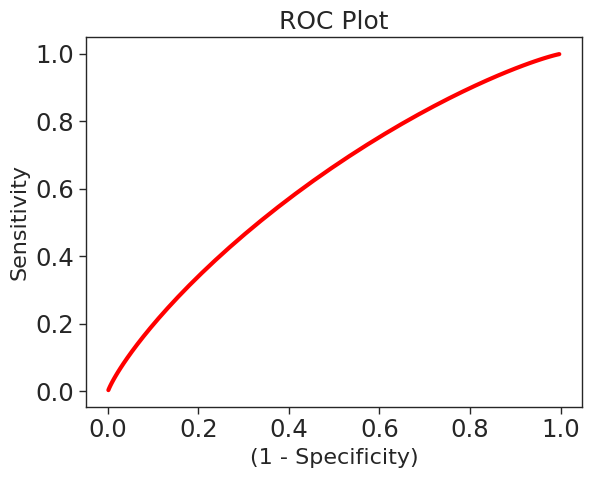

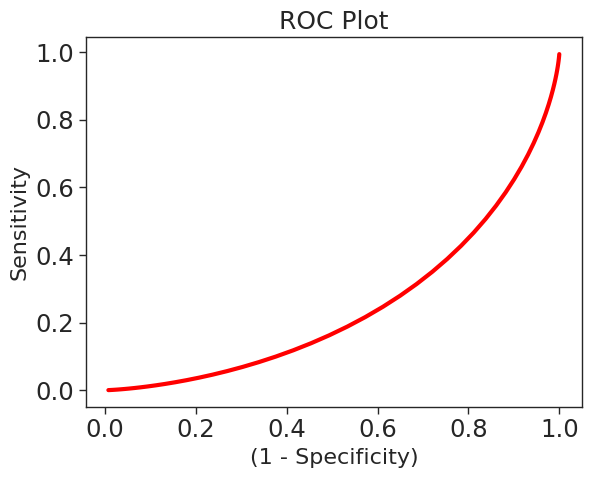

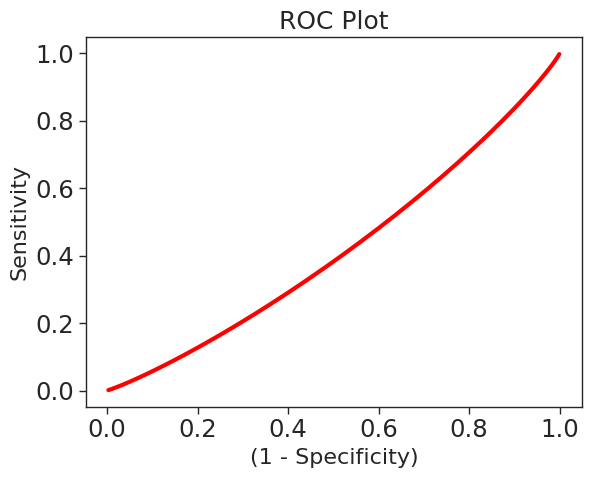

In [36]:
for model in ['MJS', 'PINES','VIDS']:
        print('MODEL', model)
        roc = Roc(input_values=np.array(smid1_moral_neutral[model].values),
                binary_outcome=np.array(smid1_moral_neutral['cond_bool'].values), 
                forced_choice=np.array(smid1_moral_neutral['sub_ix'].values))
        roc.plot()
        roc.summary()
        c0 = smid1_moral_neutral[smid1_moral_neutral['cond_bool']==True][model]
        c1 = smid1_moral_neutral[smid1_moral_neutral['cond_bool']==False][model]

        cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
        print("Cohen's d:", round(cohens_d, 2))
        print('\n')

***
## Ultimatum Game 

In [ ]:
ug_files = glob.glob("/srv/lab/fmri/mft/gan_ug/*")
ug_files.sort()

sub_info = pd.DataFrame()
for f in ug_files:
    sub_info.loc[len(sub_info), 'file'] = f
    sub_info.loc[len(sub_info)-1, 'subject'] = int(f.split('/')[-1].split('_')[0])
    sub_info.loc[len(sub_info)-1, 'ratings'] = int(f.split('/')[-1].split('_')[2][-5])

assert len(sub_info.subject.unique()) == 43

cond_map = {1:'low_unfairness', 
            2:'small_unfairness', 
            3:'moderate_unfairness', 
            4:'medium_unfairness',
            5:'high_unfairness'}

sub_info['condition'] = sub_info['ratings'].map(cond_map)
sub_info['sub_ix'] = sub_info['subject'].astype('category').cat.codes
ug_brain = Brain_Data(ug_files).standardize(axis=1)

/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/home/fhopp/.conda/envs/mjs/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [ ]:
sub_info['MJS'] = zscore(pd.Series(ug_brain.similarity(mjs, method='dot_product')))
sub_info['VIDS'] = zscore(pd.Series(ug_brain.similarity(vids, method='dot_product')))
sub_info['PINES'] = zscore(pd.Series(ug_brain.similarity(pines, method='dot_product')))

In [ ]:
mjs_r, mjs_p = stats.pearsonr(sub_info['ratings'] , sub_info['MJS'])
pines_r, pines_p = stats.pearsonr(sub_info['ratings'] , sub_info['PINES'])
vids_r, vids_p = stats.pearsonr(sub_info['ratings'] , sub_info['VIDS'])

print(f'MJS: Average overall (between- and within-subjects) correlation: r = {round(mjs_r, 2)}', mjs_p)
print(f'PINES: Average overall (between- and within-subjects) correlation: r = {round(pines_r, 2)}', pines_p)
print(f'VIDS: Average overall (between- and within-subjects) correlation: r = {round(vids_r, 2)}', vids_p)

MJS: Average overall (between- and within-subjects) correlation: r = -0.0 0.9736616502383042
PINES: Average overall (between- and within-subjects) correlation: r = 0.24 0.0003831028204320789
VIDS: Average overall (between- and within-subjects) correlation: r = 0.25 0.00019570994250084025


In [ ]:
ug_long = sub_info.melt(value_vars=['MJS', 'PINES', 'VIDS'], id_vars='ratings',
                                          var_name='model', value_name='pexp')

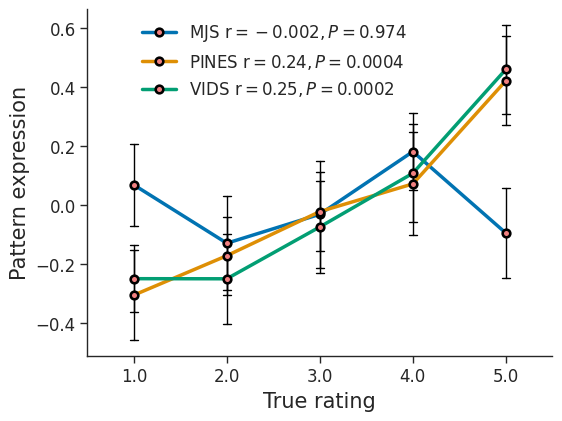

In [ ]:
#seaborn reset theme
#reset style
sns.set_theme()
sns.set_context('paper', font_scale=2)
sns.set_style("ticks")
#make all fonts a bit larger
# sns.set_theme(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6,4.5))

sns.pointplot(x='ratings', y='pexp', hue='model', data=ug_long, linewidth=2.5, capsize=0.08, palette="colorblind", errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1}, **{'markeredgecolor':'black', 'markerfacecolor':'lightcoral', 'markersize':5.5})
sns.despine()

# change fontsize of ytick labels
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# move legend to right
legend = plt.legend(bbox_to_anchor=(0.72, 0.7), frameon=False, fontsize=12)

# Add text to the legend labels
for t, l in zip(legend.texts, (r'$\mathrm{{MJS\ r}} = {}, P = {}$'.format(round(mjs_r, 3), str(mjs_p.round(3))),
                                r'$\mathrm{{PINES\ r}} = {}, P = {}$'.format(round(pines_r, 2), str(pines_p.round(4))),
                                r'$\mathrm{{VIDS\ r}} = {}, P = {}$'.format(round(vids_r, 2), str(vids_p.round(4))), 
                                )):
    t.set_text(l)

plt.ylabel('Pattern expression',fontsize=15)
plt.xlabel('True rating', fontsize=15)
plt.savefig('../../plots/external_comparisons_UG.png', dpi=300, bbox_inches='tight')
plt.show()

### High vs. Low Unfairness

In [ ]:
high_low = sub_info.copy()
del high_low['file']
high_low = high_low[high_low['condition'].isin(["low_unfairness", "high_unfairness"])]
high_low = high_low.groupby(['subject', 'condition']).mean().reset_index()
high_low['cond_bool'] = high_low['condition'].apply(lambda x: True if x == 'high_unfairness' else False)

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.35
Accuracy SE:        0.05
Accuracy p-value:   0.07
Sensitivity:        0.44
Specificity:        0.44
AUC:                0.44
PPV:                0.44
------------------------


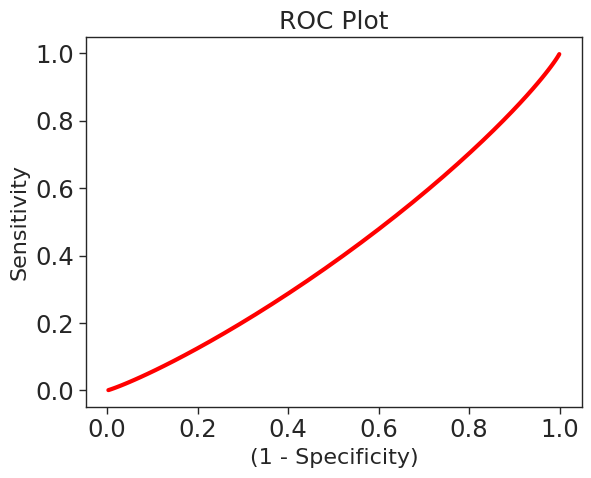

In [ ]:
roc = Roc(input_values=np.array(high_low['MJS'].values),
          binary_outcome=np.array(high_low['cond_bool'].values), 
          forced_choice=np.array(high_low['sub_ix'].values))
roc.plot()
roc.summary()

In [ ]:
c0 = high_low[high_low['condition']=='high_unfairness']['MJS']
c1 = high_low[high_low['condition']=='low_unfairness']['MJS']

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print("Cohen's d:", round(cohens_d, 2))

Cohen's d: -0.17


------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.70
Accuracy SE:        0.11
Accuracy p-value:   0.01
Sensitivity:        0.71
Specificity:        0.71
AUC:                0.71
PPV:                0.71
------------------------


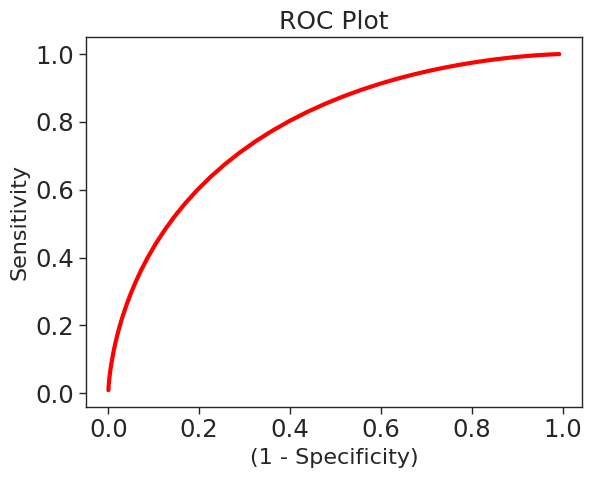

In [ ]:
roc = Roc(input_values=np.array(high_low['PINES'].values),
          binary_outcome=np.array(high_low['cond_bool'].values), 
          forced_choice=np.array(high_low['sub_ix'].values))
roc.plot()
roc.summary()

In [ ]:
c0 = high_low[high_low['condition']=='high_unfairness']['PINES']
c1 = high_low[high_low['condition']=='low_unfairness']['PINES']

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print("Cohen's d:", round(cohens_d, 2))

Cohen's d: 0.73


------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.74
Accuracy SE:        0.11
Accuracy p-value:   0.00
Sensitivity:        0.74
Specificity:        0.74
AUC:                0.74
PPV:                0.74
------------------------


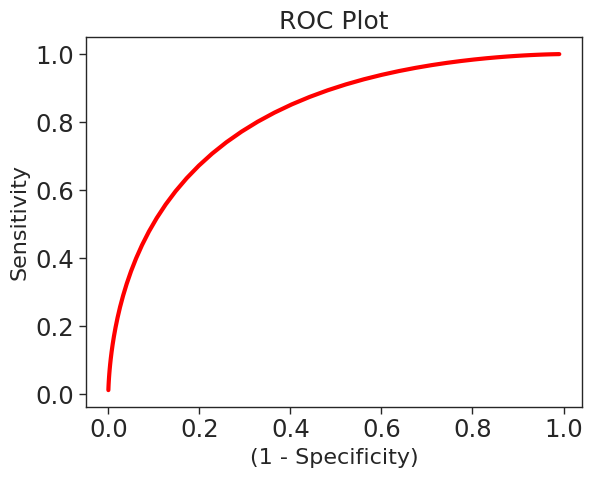

In [ ]:
roc = Roc(input_values=np.array(high_low['VIDS'].values),
          binary_outcome=np.array(high_low['cond_bool'].values), 
          forced_choice=np.array(high_low['sub_ix'].values))
roc.plot()
roc.summary()

In [ ]:
c0 = high_low[high_low['condition']=='high_unfairness']['VIDS']
c1 = high_low[high_low['condition']=='low_unfairness']['VIDS']

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
print("Cohen's d:", round(cohens_d, 2))

Cohen's d: 0.81
